# Make a custom dataset: CIFAR10
<img src='https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png'>



The [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

CIFAR10 dataset is provided ready-to-use by the `torchvision.datasets` package, but in this case we want create our custom CIFAR10Dataset class starting from the original images. 

In [1]:
import torch
from torch.utils.data import Subset
import torchvision.transforms as T
import random
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
!wget -c https://github.com/YoongiKim/CIFAR-10-images/archive/master.tar.gz
!tar -xzf master.tar.gz
!rm master.tar.gz
!rm ./CIFAR-10-images-master/README.md

--2023-03-30 17:53:29--  https://github.com/YoongiKim/CIFAR-10-images/archive/master.tar.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/YoongiKim/CIFAR-10-images/tar.gz/refs/heads/master [following]
--2023-03-30 17:53:29--  https://codeload.github.com/YoongiKim/CIFAR-10-images/tar.gz/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘master.tar.gz’

master.tar.gz           [       <=>          ]  18.74M  14.0MB/s    in 1.3s    

2023-03-30 17:53:31 (14.0 MB/s) - ‘master.tar.gz’ saved [19652285]



In [3]:
import os
dest_dir = "./CIFAR-10-images-master"
os.listdir(dest_dir)

['test', 'train']

In [4]:
class MyCifar10Dataset(Dataset):
  def __init__(self, dset_dir, train=True, transforms=T.Compose([])):
    split = "train" if train else "test"
    self.dset_dir = Path(dset_dir)/split
    
    self.transforms = transforms

    self.files = []

    folders = sorted(os.listdir(self.dset_dir))
    for folder in folders:
      class_idx = folders.index(folder)

      folder_dir = self.dset_dir/folder

      files = os.listdir(folder_dir)

      self.files += [{"file": folder_dir/x, "class": class_idx} for x in files]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    item = self.files[i]
    file = item['file']
    class_idx = torch.tensor(item['class'])

    img = Image.open(file).convert("RGB")
    img = self.transforms(img)
    return img, class_idx

In [5]:
transforms = T.Compose([
        T.Resize(32),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [6]:
train_dset = MyCifar10Dataset(dest_dir, train=True, transforms=transforms)
test_dset = MyCifar10Dataset(dest_dir, train=False, transforms=transforms)

num_train = len(train_dset)
num_test = len(test_dset)

print(f"Num. training samples: {num_train}")
print(f"Num. test samples:     {num_test}")

train_idx = list(range(num_train))
test_idx = list(range(num_test))

random.shuffle(train_idx)

# Fraction of the original train set that we want to use as validation set
val_frac = 0.2
# Number of samples of the validation set
num_val = int(num_train * val_frac) 
num_train = num_train - num_val

print('new num_train: ', num_train)
print('num_ val: ', num_val)


# Split training set
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]

val_dset = Subset(train_dset, val_idx)
train_dset = Subset(train_dset, train_idx)

Num. training samples: 50000
Num. test samples:     10000
new num_train:  40000
num_ val:  10000


In [7]:
batch_s = 16

train_loader = DataLoader(train_dset, batch_size=batch_s, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_dset, batch_size = batch_s, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_dset, batch_size=batch_s, shuffle=False, drop_last=False, num_workers=2)

In [8]:
print(len(train_loader), len(val_loader), len(test_loader))

2500 625 625


In [9]:
inputs, labels = next(iter(train_loader))
print(inputs.shape)
print(labels.shape)

torch.Size([16, 3, 32, 32])
torch.Size([16])


#TODO: Classification on CIFAR-10 with a CNN

Define your *personal* Convolutional Neural Network and try to solve the CIFAR10 classification problem.

In [10]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    outputs = net(input)
                    loss = criterion(outputs, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    preds = torch.argmax(outputs, 1)
                    batch_accuracy = (preds == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [11]:
print('GPU available: ', torch.cuda.is_available())
dev = torch.device('cuda')
print(dev)

GPU available:  True
cuda


In [12]:
class net(nn.Module):
  def __init__(self):
    super().__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.20),
        nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.25),
        nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.linears = nn.Sequential(
        nn.Linear(256 * 4 * 4, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, 256 * 4 * 4)
    x = self.linears(x)
    #x = nn.Softmax(x)
    return x

In [13]:
model = net()
print(model)

net(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linears): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, 

In [14]:
# hyper parameters
epochs = 20
initial_lr = 0.001
w_decay = 0.00001

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

In [15]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

net(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linears): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, 

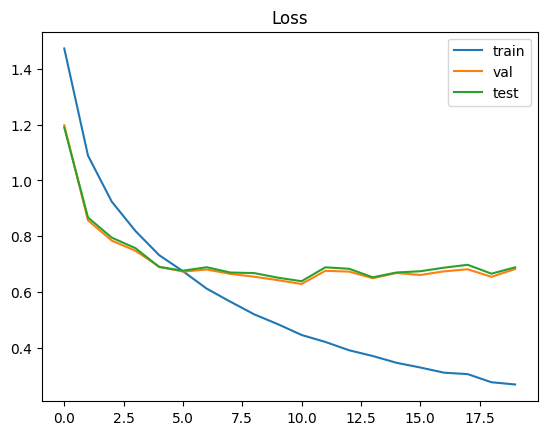

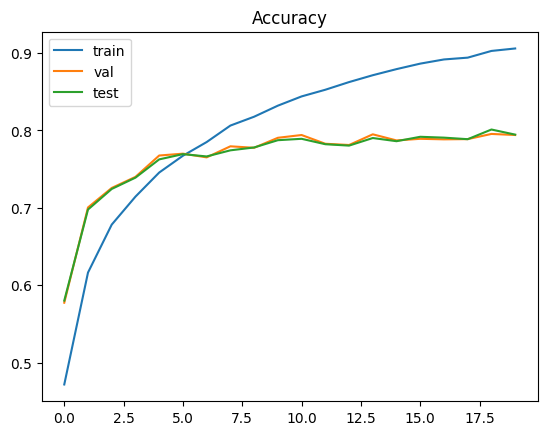

In [16]:
train(model, loaders, optimizer, loss_fn, epochs=epochs, dev=dev)